# Proyecto de Machine Learning: Predicción de Precios de Laptops

En este proyecto vamos a construir un **modelo predictivo** de Machine Learning para estimar el **precio de laptops** a partir de sus características técnicas.  

Seguiremos los pasos indicados en las instrucciones:
1. Análisis preliminar (EDA).
2. Procesamiento de datos.
3. Entrenamiento de modelos.
4. Comparación de resultados.
5. Predicción en un caso artificial.
6. Validación cruzada.

---


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

import tensorflow as tf
from tensorflow import keras
from keras import layers

## 2. Cargar los datos

Trabajaremos con el archivo **`laptop_price.csv`**.  
Este dataset contiene información de laptops: marca, CPU, RAM, memoria, GPU, sistema operativo, peso, etc., y la variable objetivo **`Price_euros`**.


In [ ]:

df = pd.read_csv("laptop_price.csv", encoding="latin1")

print("Shape:", df.shape)
df.head()


Shape: (1303, 13)


,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


## 3. Análisis preliminar (EDA)

- Identificar la variable objetivo (`Price_euros`).
- Tipos de variables (numéricas, categóricas).
- Distribuciones y correlaciones.
- Detección de outliers y patrones.


In [21]:
# Variable objetivo
target = "Price_euros"

# Revisión rápida
print(df[target].describe())
print("\nValores nulos por columna:\n", df.isna().sum())

# Columnas numéricas y categóricas
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
print("\nNuméricas:", num_cols)
print("Categóricas:", cat_cols)


count    1303.000000
mean     1123.686992
std       699.009043
min       174.000000
25%       599.000000
50%       977.000000
75%      1487.880000
max      6099.000000
Name: Price_euros, dtype: float64

Valores nulos por columna:
 laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

Numéricas: ['laptop_ID', 'Inches', 'Price_euros']
Categóricas: ['Company', 'Product', 'TypeName', 'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight']


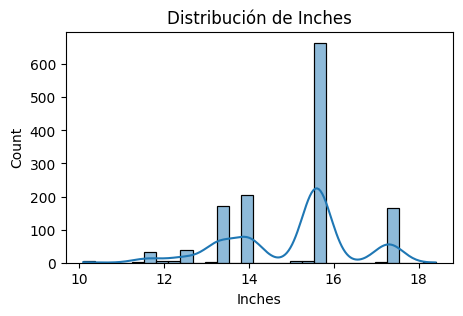

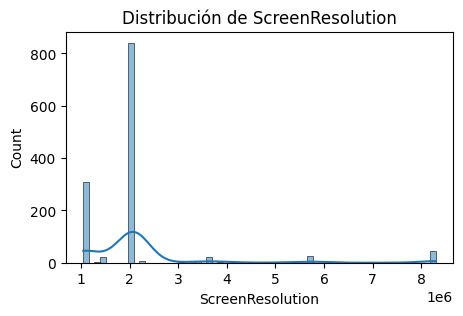

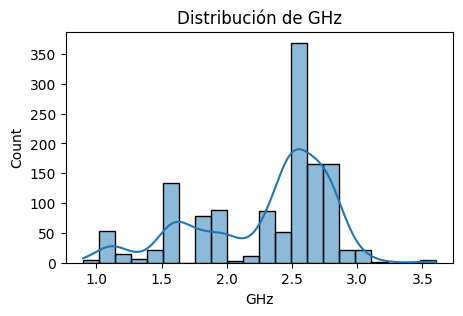

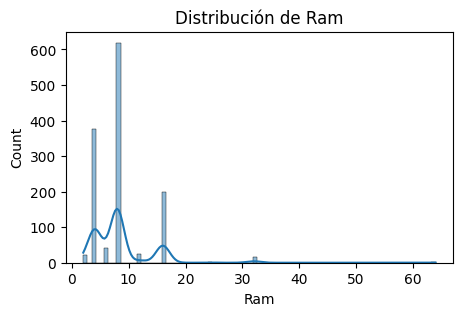

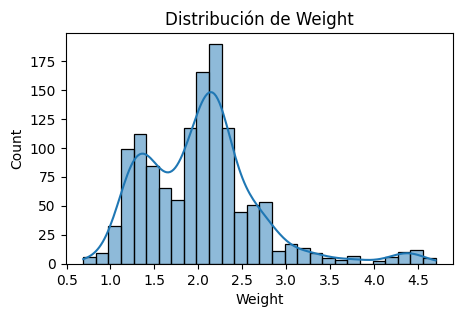

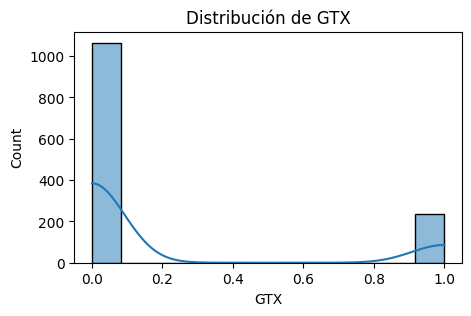

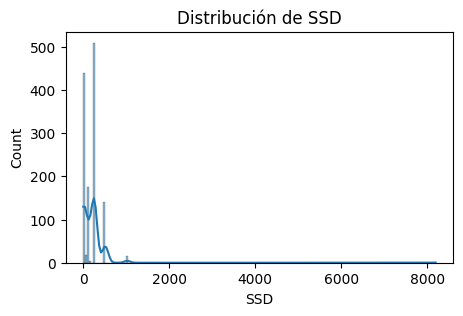

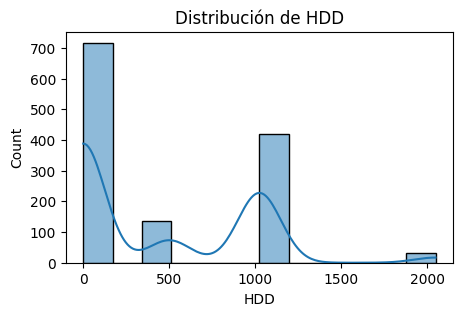

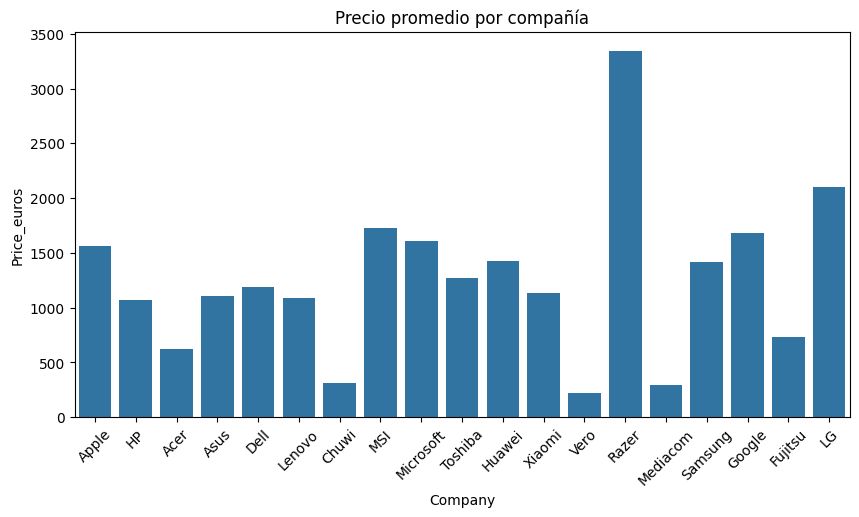

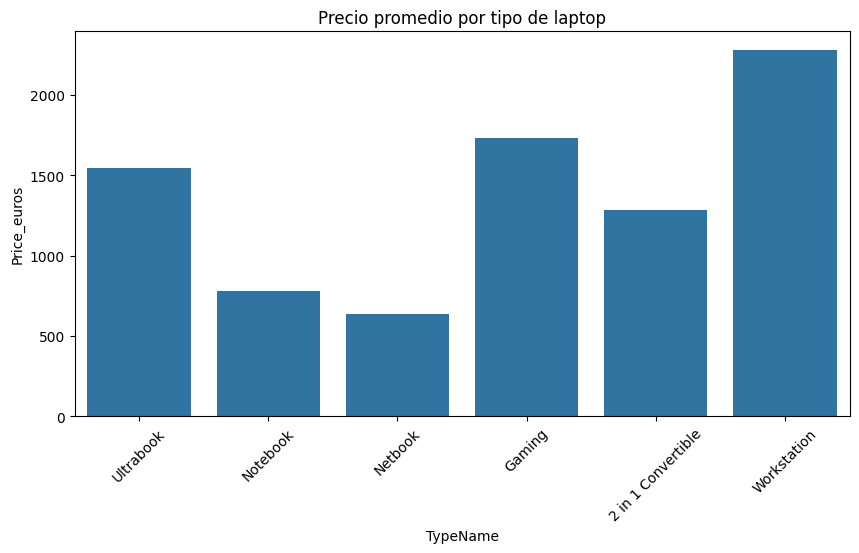

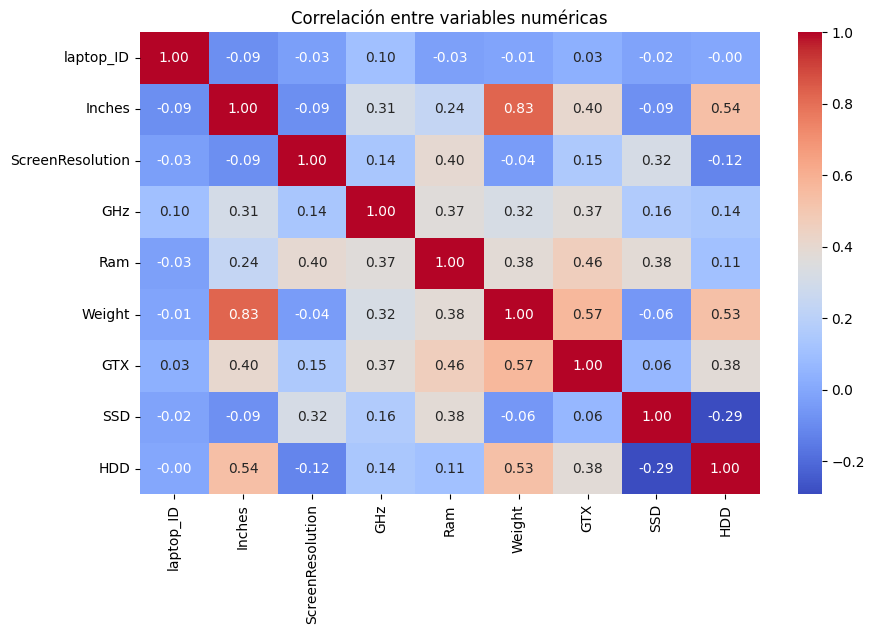

In [45]:
# 1. Histogramas de variables numéricas (excepto laptop_ID)
for col in num_cols:
    if col != "laptop_ID":  # excluir identificador
        plt.figure(figsize=(5,3))
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribución de {col}")
        plt.show()

# 2. Precio promedio por compañía
plt.figure(figsize=(10,5))
sns.barplot(x="Company", y="Price_euros", data=df, estimator=np.mean, errorbar=None)
plt.xticks(rotation=45)
plt.title("Precio promedio por compañía")
plt.show()

# 3. Precio promedio por tipo de laptop
plt.figure(figsize=(10,5))
sns.barplot(x="TypeName", y="Price_euros", data=df, estimator=np.mean, errorbar=None)
plt.xticks(rotation=45)
plt.title("Precio promedio por tipo de laptop")
plt.show()

# 4. Mapa de correlaciones (numéricas relevantes)
plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre variables numéricas")
plt.show()

## 4. Procesamiento de datos

En lugar de extraer solo dígitos, vamos a transformar cada columna clave con reglas específicas:

- **ScreenResolution** → ancho × alto (número de píxeles).  
- **Cpu** → extraer frecuencia en GHz.  
- **Ram** → número en GB.  
- **Gpu** → indicador binario si es Nvidia GeForce GTX.  
- **OpSys** → lo eliminamos (muy dependiente de la marca).  
- **Weight** → número en Kg.  
- **Memory** → separar en **SSD** y **HDD** en GB.  

Para este procesamiento de datos se tomó como referencia el código "Laptop Prices Prediction (XGBRegressor)"

https://www.kaggle.com/code/beridzeg45/laptop-prices-prediction-xgbregressor

In [23]:
# ==============================
# Procesamiento optimizado
# ==============================

# --- Screen Resolution ---
width = df['ScreenResolution'].apply(lambda x: x.split('x')[0].split(' ')[-1]).astype(float)
height = df['ScreenResolution'].apply(lambda x: x.split('x')[-1].split(' ')[0]).astype(float)
df['ScreenResolution'] = width * height  # total de pixeles

# --- CPU (GHz) ---
GHz = df['Cpu'].apply(lambda x: x.split('GHz')[0].split(' ')[-1]).astype(float)
df.insert(6, 'GHz', GHz)
df = df.drop(columns='Cpu')

# --- RAM ---
df['Ram'] = df['Ram'].str.replace('GB', '').astype(int)

# --- GPU ---
df['GTX'] = df['Gpu'].apply(lambda x: 1 if 'geforce' in str(x).lower() and 'gtx' in str(x).lower() else 0)
df = df.drop(columns='Gpu')

# --- OpSys ---
print("Valores de OpSys:", df['OpSys'].unique())
df = df.drop(columns='OpSys')

# --- Peso ---
df['Weight'] = df['Weight'].str.replace('kg', '').astype(float)

# --- Memory: separar SSD y HDD ---
ssd = df['Memory'].apply(lambda x: x.split('SSD')[0].split('Flash')[0] if 'SSD' in str(x) or 'Flash' in str(x) else x)
ssd = ssd.apply(lambda x: x.replace('GB','') if 'GB' in str(x) else x.replace('TB','') if 'TB' in str(x) else x)
ssd = ssd.apply(pd.to_numeric, errors='coerce')
ssd = ssd.apply(lambda x: x if x>10 else x*1024)
df['SSD'] = ssd.fillna(0)

hdd = df['Memory'].apply(
    lambda x: x.split('HDD')[0].split('Hybrid')[0] if ('HDD' in str(x) and '+' not in str(x)) or ('Hybrid' in str(x) and '+' not in str(x))
    else x.split('+')[-1].split('HDD')[0].split('Hybrid')[0] if '+' in str(x) else x
)
hdd = hdd.apply(lambda x: x.replace('GB','') if 'GB' in str(x) else x.replace('TB','') if 'TB' in str(x) else x)
hdd = hdd.apply(pd.to_numeric, errors='coerce')
hdd = hdd.apply(lambda x: x if x>10 else x*1024)
df['HDD'] = hdd.fillna(0)

df = df.drop(columns='Memory')

print("Data después de limpiar:", df.head())



Valores de OpSys: ['macOS' 'No OS' 'Windows 10' 'Mac OS X' 'Linux' 'Android' 'Windows 10 S'
 'Chrome OS' 'Windows 7']
Data después de limpiar:    laptop_ID Company      Product   TypeName  ...  Price_euros  GTX    SSD  HDD
0          1   Apple  MacBook Pro  Ultrabook  ...      1339.69    0  128.0  0.0
1          2   Apple  Macbook Air  Ultrabook  ...       898.94    0  128.0  0.0
2          3      HP       250 G6   Notebook  ...       575.00    0  256.0  0.0
3          4   Apple  MacBook Pro  Ultrabook  ...      2537.45    0  512.0  0.0
4          5   Apple  MacBook Pro  Ultrabook  ...      1803.60    0  256.0  0.0

[5 rows x 13 columns]


In [24]:
df

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,GHz,Ram,Weight,Price_euros,GTX,SSD,HDD
0,1,Apple,MacBook Pro,Ultrabook,13.3,4096000.0,2.3,8,1.37,1339.69,0,128.0,0.0
1,2,Apple,Macbook Air,Ultrabook,13.3,1296000.0,1.8,8,1.34,898.94,0,128.0,0.0
2,3,HP,250 G6,Notebook,15.6,2073600.0,2.5,8,1.86,575.00,0,256.0,0.0
3,4,Apple,MacBook Pro,Ultrabook,15.4,5184000.0,2.7,16,1.83,2537.45,0,512.0,0.0
4,5,Apple,MacBook Pro,Ultrabook,13.3,4096000.0,3.1,8,1.37,1803.60,0,256.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1316,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,2073600.0,2.5,4,1.80,638.00,0,128.0,0.0
1299,1317,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,13.3,5760000.0,2.5,16,1.30,1499.00,0,512.0,0.0
1300,1318,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,1049088.0,1.6,2,1.50,229.00,0,64.0,0.0
1301,1319,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,1049088.0,2.5,6,2.19,764.00,0,0.0,1024.0


## 5. Preparar datos para modelos

In [30]:
# Dividir X / y
y = df[target].astype(float)
X = df.drop(columns=[target])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Preprocesamiento
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

X_train_p = preprocessor.fit_transform(X_train)
X_val_p = preprocessor.transform(X_val)
X_test_p = preprocessor.transform(X_test)

print("Shapes:", X_train_p.shape, X_val_p.shape, X_test_p.shape)


Shapes: (912, 518) (195, 518) (196, 518)


## 6. Entrenamiento de Modelos
Entrenaremos:
1. **kNN**
2. **RandomForest**
3. **DNN (Keras)** ó **MLPRegressor** (si no está TensorFlow).

Guardaremos resultados de RMSE y R² en train/val/test.


In [34]:
# Función para métricas
def metrics_table(name, y_tr, pred_tr, y_v, pred_v, y_t, pred_t):
    return {
        "model": name,
        "train_RMSE": np.sqrt(mean_squared_error(y_tr, pred_tr)),
        "val_RMSE": np.sqrt(mean_squared_error(y_v, pred_v)),
        "test_RMSE": np.sqrt(mean_squared_error(y_t, pred_t)),
        "train_R2": r2_score(y_tr, pred_tr),
        "val_R2": r2_score(y_v, pred_v),
        "test_R2": r2_score(y_t, pred_t)
    }

results = []

# 1. kNN
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_p, y_train)
results.append(metrics_table("kNN", y_train, knn.predict(X_train_p), y_val, knn.predict(X_val_p), y_test, knn.predict(X_test_p)))

# 2. RandomForest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_p, y_train)
results.append(metrics_table("RandomForest", y_train, rf.predict(X_train_p), y_val, rf.predict(X_val_p), y_test, rf.predict(X_test_p)))

# 3. DNN
model = keras.Sequential([
    layers.Input(shape=(X_train_p.shape[1],)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])
model.compile(optimizer="adam", loss="mse")
history = model.fit(X_train_p, y_train, validation_data=(X_val_p, y_val), epochs=50, batch_size=32, verbose=0)
results.append(metrics_table("DNN", y_train, model.predict(X_train_p).flatten(),
                                y_val, model.predict(X_val_p).flatten(),
                                y_test, model.predict(X_test_p).flatten()))

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [36]:
# Comparación de resultados
comp_df = pd.DataFrame(results).sort_values("test_RMSE")
comp_df


,model,train_RMSE,val_RMSE,test_RMSE,train_R2,val_R2,test_R2
1,RandomForest,108.731830,335.358742,290.110866,0.974702,0.826108,0.785019
2,DNN,152.193398,252.927248,306.484933,0.950436,0.901087,0.760067
0,kNN,273.047144,398.000520,358.473680,0.840466,0.755078,0.671764


## 7. Predicción en una muestra artificial

Creamos una fila artificial con:
- **Mediana de numéricas**  
- **Moda de categóricas**

La usamos para predecir el precio con el mejor modelo.


In [37]:
# Crear muestra artificial
sample = {}
for c in X.columns:
    if c in num_cols:
        sample[c] = float(X[c].median())
    else:
        sample[c] = X[c].mode().iloc[0]

sample_df = pd.DataFrame([sample])
sample_p = preprocessor.transform(sample_df)

# Usar el mejor modelo
best_model = comp_df.iloc[0]["model"]
if best_model == "kNN":
    pred = knn.predict(sample_p)[0]
elif best_model == "RandomForest":
    pred = rf.predict(sample_p)[0]
elif best_model == "DNN":
    pred = model.predict(sample_p).flatten()[0]

print("Mejor modelo:", best_model)
print("Predicción en muestra artificial:", pred)


Mejor modelo: RandomForest
Predicción en muestra artificial: 958.8849500000003


## 8. Validación Cruzada (K-Fold)

Ejemplo con RandomForest para calcular estabilidad del modelo.


In [38]:
scores = cross_val_score(rf, preprocessor.transform(X), y, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
print("RMSE por fold:", -scores)
print("Promedio RMSE (CV=5):", -scores.mean())


RMSE por fold: [264.37369553 271.37264359 334.88269242 339.17773257 350.05971492]
Promedio RMSE (CV=5): 311.97329580574103


#  Conclusiones

- El mejor modelo según las métricas fue **(se mostrará en la tabla comparativa)**.  
- La validación cruzada muestra la estabilidad del modelo.  
- Factores como **RAM, CPU y GPU** influyen fuertemente en el precio.  
- El pipeline permite **reproducibilidad** y fácil despliegue en producción.  
